In [1]:
import tkinter as tk
from tkinter import filedialog, ttk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import seaborn as sns

In [14]:
mergedData = pd.read_csv("MergedDataFull.csv")
mergedData.set_index("sampleid", inplace=True)
mergedData.iloc[:,0:294].dtypes
mergedData.select_dtypes(include=['int']).columns[0:294]

Index(['Pneumocystis', 'Candida', 'Saccharomyces', 'Fusarium', 'Cyphellophora',
       'Penicillium', 'Aspergillus', 'Malassezia', 'Jonquetella',
       'Cloacibacillus',
       ...
       'Phikzvirus', 'Tunavirus', 'Rhadinovirus', 'Elvirus', 'Chivirus',
       'Jiaodavirus', 'Webervirus', 'Vectrevirus', 'Alphapolyomavirus',
       'Fromanvirus'],
      dtype='object', length=294)

2024-12-13 17:35:40.374 python[66187:8414150] +[CATransaction synchronize] called within transaction


Data loaded successfully.
PCA plot updated.


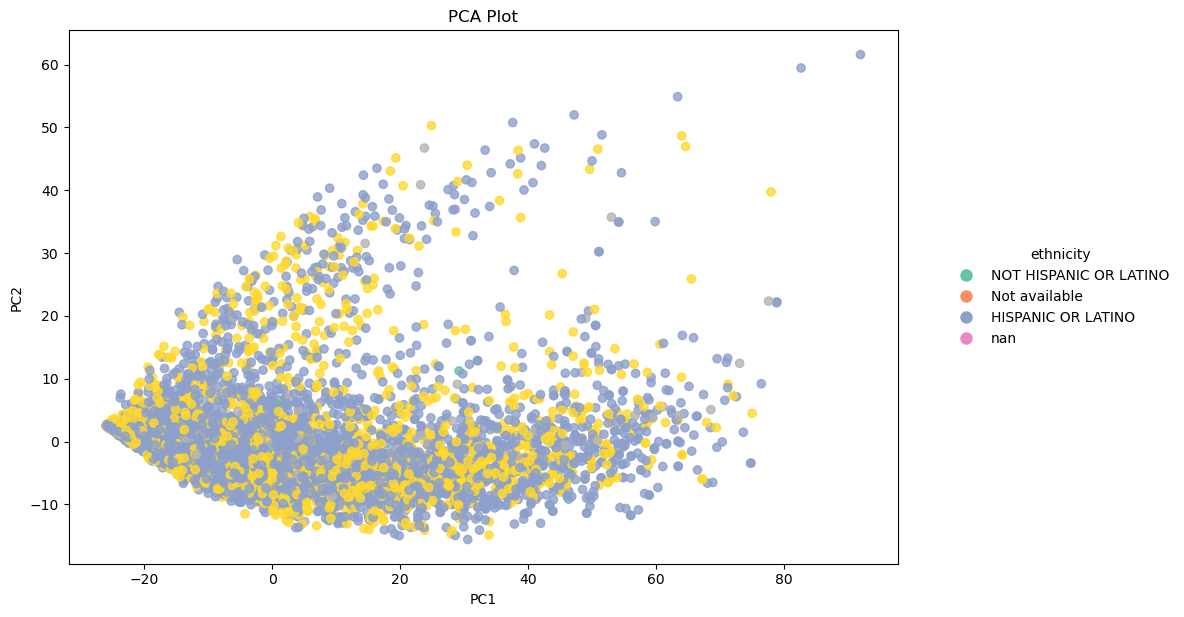

In [2]:
class PCAGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("PCA GUI")

        # Variables
        self.data = None
        self.microbial_data = None
        self.metadata = None
        self.colorbar = None  # Track existing colorbar

        # GUI Layout
        self.create_widgets()

    def create_widgets(self):
        # Load data button
        self.load_button = tk.Button(self.root, text="Load Data", command=self.load_data)
        self.load_button.pack(pady=10)

        # Dropdown for color variable
        self.color_label = tk.Label(self.root, text="Color by:")
        self.color_label.pack()
        self.color_var = tk.StringVar(self.root)
        self.color_dropdown = ttk.Combobox(self.root, textvariable=self.color_var, state="readonly")
        self.color_dropdown.pack(pady=5)

        # PCA button
        self.pca_button = tk.Button(self.root, text="Run PCA", command=self.run_pca, state="disabled")
        self.pca_button.pack(pady=10)

        # Plot area
        self.figure, self.ax = plt.subplots(figsize=(12, 10))
        self.canvas = FigureCanvasTkAgg(self.figure, self.root)
        self.canvas.get_tk_widget().pack()

    def load_data(self):
        # Load data file
        file_path = filedialog.askopenfilename(title="Select a CSV file", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        self.data = pd.read_csv(file_path)
        
        # Assume microbial counts are at the beginning and metadata follows
        microbial_columns = self.data.select_dtypes(include=['number']).columns
        self.microbial_data = self.data[microbial_columns]
        self.metadata = self.data.drop(columns=microbial_columns)

        # Populate dropdown with metadata columns
        self.color_dropdown["values"] = list(self.metadata.columns)
        self.color_var.set(self.metadata.columns[0])
        
        # Enable PCA button
        self.pca_button["state"] = "normal"
        print("Data loaded successfully.")

    def run_pca(self):
        if self.microbial_data is None or self.metadata is None:
            print("Data not loaded.")
            return

        # Normalize microbial data by log(counts / row sum + 1e-10)
        normalized_data = self.microbial_data.div(self.microbial_data.sum(axis=1) + 1e-10, axis=0)
        log_normalized_data = np.log(normalized_data + 1e-10)

        # Handle missing values by replacing NaNs with column mean
        log_normalized_data.fillna(log_normalized_data.mean(), inplace=True)

        # Perform PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(log_normalized_data)
        
        # Get selected color variable
        color_var = self.color_var.get()
        if color_var not in self.metadata.columns:
            print("Invalid color variable.")
            return

        colors = self.metadata[color_var]
        unique_labels, unique_colors = pd.factorize(colors)
        cmap = sns.color_palette("Set2", n_colors=len(pd.unique(colors)))

        # Plot PCA
        self.ax.clear()
        scatter = self.ax.scatter(pca_result[:, 0], pca_result[:, 1], c=unique_labels, cmap="Set2", alpha=0.8)
        self.ax.set_title("PCA Plot")
        self.ax.set_xlabel("PC1")
        self.ax.set_ylabel("PC2")

        # Remove existing colorbar if present
        if self.colorbar:
            self.colorbar.remove()

        # Add new legend with category names
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap[i], markersize=10) for i in range(len(pd.unique(colors)))]
        legend = self.ax.legend(handles, pd.unique(colors), title=color_var, loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)

        # Adjust layout to prevent legend cutoff
        self.figure.tight_layout()

        self.canvas.draw()
        print("PCA plot updated.")

if __name__ == "__main__":
    root = tk.Tk()
    app = PCAGUI(root)
    root.mainloop()
